# golive2

A continuation of the **golive** Jupyter notebook (keeping it stable).


The pre-masked speed 'vv_masked' is the observation of interest: How does it vary over
the course of several years? I can think of a couple 'color vis' approaches without much thought:


1. Empirical: For each location and across annual time bins (say 1/10th of a year) accumulate 
mean speed and std dev with the idea of 're-coloring' everything by std dev / mean or for a given 
time using speed / mean speed. (Is this 'frequentist'?)


2. Treat each location + time series as a vector and apply a clustering algorithm like k-means.
(Is this 'bayesian'?)


Accumulating these data is most easily done using the xarray 


: Do we generate a 2D array of lists
that accumulate from each dataset? Or do we go with time built-in as a third dimension?  Each 
addition is from a pixel from the 819 (easting) x 828 (northing) grid; and at a certain mean-day; 
and with a particular L8 time interval (16, 32, 48, 64, 80). 


accumulator(x, y) += (t, dt, vx, vy, vv, corr, del_corr) 


Some screening on ingest: using lgo_mask and an ad hoc thresold on maximum speed.


Post-hoc screening: vx, vy consistent with other observations 


In [1]:
# Some Python utility code
from pathlib import Path
home_d = str(Path.home()) + '/'
data_d = home_d + 'data/'             # A non-repository location for datasets of interest

def dirobj(obj): return [x for x in dir(obj) if not x.startswith('_')]

def lsal(path=''):
    import os
    return os.popen('ls -al ' + path).readlines()

def ShowGitHubImage(username, repo, folder, source, localpath, localname, width, height):
    global home_d
    import requests, shutil
    from PIL import Image
    outf = localpath + '/' + localname
    f = 'https://raw.githubusercontent.com/' + username + '/' + repo + '/master/' + folder + '/' + source
    a = requests.get(f, stream = True)
    if a.status_code == 200:
        with open(outf, 'wb') as f:
            a.raw.decode_content = True
            shutil.copyfileobj(a.raw, f)
    return Image.open(outf).resize((width,height),Image.ANTIALIAS)

def ShowLocalImage(path, filename, width, height):
    from PIL import Image
    f = path + '/' + filename 
    return Image.open(f).resize((width,height),Image.ANTIALIAS)

# Test either of the 'Show Image' functions
# ShowGitHubImage('robfatland', 'othermathclub', 'images/cellular', 'conus_textile_shell_2.png', home_d, 'ctextile.jpg', 450, 250)
# ShowLocalImage(home_d, 'ctextile.jpg', 450, 250)

In [2]:
# what we need to get stuff done
!pip install utm

%matplotlib inline
from matplotlib import pyplot as plt
import pandas as pd
import netCDF4
import xarray as xr
from xarray import Dataset
import numpy as np
from ftplib import FTP
import utm

You are using pip version 9.0.1, however version 18.1 is available.
You should consider upgrading via the 'pip install --upgrade pip' command.


In [3]:
# file grabbing code... this takes a few minutes 
golive2_d = data_d + 'golive2/'

if False:
    ftp = FTP('dtn.rc.colorado.edu')
    ftp.login()
    ftp.cwd('work/nsidc0710/nsidc0710_landsat8_golive_ice_velocity_v1.1/p063_r018')
    a=[]
    ftp.dir(a.append)    # This is a rather tricky line of Python as it passes an append method as an argument
    d = [b.split()[8] for b in a if len(b.split()) == 9 and b.split()[8][-3:]=='.nc']
    for i in range(len(d)):
        ftp.retrbinary('RETR ' + d[i], open(golive2_d + d[i], 'wb').write)  
        print('obtained file', i)
    ftp.quit()
    print(len(d))
    # for c in d: print(c)

In [4]:
ds = xr.open_mfdataset(golive2_d + 'L8_063_018_016_2013_143_2013_159_v1.1.nc')
# ds1['image_pair_times']
# ds1['time'] = xr.Variable('time', ds1['image_pair_times'].attrs['mid_date'])
# ds1
print(type(ds['image_pair_times'].attrs['mid_date']))
print(ds['image_pair_times'].attrs['mid_date'])
s = ds['image_pair_times'].attrs['mid_date']
ts = pd.Timestamp(s)
ds['time'] = xr.Variable('time', [ts])
ds

<class 'str'>
2013-05-31T00:00:00


<xarray.Dataset>
Dimensions:                                         (chars: 4280, time: 1, x: 803, y: 786)
Coordinates:
  * x                                               (x) float64 3.373e+05 ...
  * y                                               (y) float64 6.779e+06 ...
  * chars                                           (chars) int32 0 1 2 3 4 ...
  * time                                            (time) datetime64[ns] 2013-05-31 ...
Data variables:
    image_pair_times                                |S1 ...
    input_image_details                             |S1 ...
    transverse_mercator                             |S1 ...
    offset_correction                               |S1 ...
    applied_bilinear_x_offset_correction_in_pixels  (y, x) float32 dask.array<shape=(786, 803), chunksize=(786, 803)>
    applied_bilinear_y_offset_correction_in_pixels  (y, x) float32 dask.array<shape=(786, 803), chunksize=(786, 803)>
    vx                                              (y, x) flo

In [43]:
#ds1
#ds1.squeeze('chars', drop=True)
#ds1['vv_masked'].sel(x=':', )
#del ds1['chars']
#ds1 = ds1.sel(x=slice(-1), y=slice(-1))
#ds1
# def pp(ds1):
#     del ds1['processing_log']
#     del ds1['chars']
#     ds1.rename({'chars':'band'},inplace=True)
#     return ds1.assign_coords(band=1)

from datetime import timedelta
tslist = []

def pp(ds):
    global tslist
    s = ds['image_pair_times'].attrs['mid_date']
    ts = pd.Timestamp(s)
    while ts in tslist: ts += timedelta(hours = 1)
    tslist.append(ts)
    ds['time'] = xr.Variable('time', [ts])
    return ds

m = xr.open_mfdataset(golive2_d + '*.nc', preprocess = pp, decode_cf=False, autoclose=True, concat_dim='time')

print('there are', len(tslist), 'files in play')

there are 255 files in play


In [44]:
m

<xarray.Dataset>
Dimensions:                                         (chars: 4534, time: 255, x: 840, y: 829)
Coordinates:
  * chars                                           (chars) int64 0 1 2 3 4 ...
  * time                                            (time) datetime64[ns] 2013-05-07 ...
  * x                                               (x) float64 3.325e+05 ...
  * y                                               (y) float64 6.537e+06 ...
Data variables:
    image_pair_times                                (time) object b'' b'' ...
    input_image_details                             (time) object b'' b'' ...
    transverse_mercator                             (time) object b'' b'' ...
    offset_correction                               (time) object b'' b'' ...
    applied_bilinear_x_offset_correction_in_pixels  (time, y, x) float32 dask.array<shape=(255, 829, 840), chunksize=(1, 829, 840)>
    applied_bilinear_y_offset_correction_in_pixels  (time, y, x) float32 dask.array<shape=(2

In [45]:
len(m['time'])

255

In [46]:
# print(m['image_pair_times'])
m['image_pair_times'].time.values[200]

numpy.datetime64('2017-08-22T00:00:00.000000000')

In [47]:
vxm = m.vx_masked
vym = m.vy_masked
vvm = m.vv_masked
corr = m.corr
dcorr = m.del_corr

In [48]:
# Endpoints determined off of a map representing four lateral transects of Seward glacier
ends = []

ends.append(((60.104166,-140.478055),(60.079166,-140.421944)))
ends.append(((60.150833,-140.494444),(60.14611,-140.400277)))
ends.append(((60.189722,-140.456388),(60.17083,-140.389722)))
ends.append(((60.242222,-140.417500),(60.21805,-140.300277)))

nTransects = len(ends)

utm0, utm1 = [], []
for i in range(nTransects):
    utm0.append(utm.from_latlon(ends[i][0][0],ends[i][0][1]))     # 4-plets
    utm1.append(utm.from_latlon(ends[i][1][0],ends[i][1][1]))

from numpy.linalg import norm
posting = 100.                         # meters

# The following lists have index across the various transects
transects = [(utm1[i][0]-utm0[i][0], utm1[i][1]-utm0[i][1]) for i in range(nTransects)]   # single vector spanning the transect
lengths = [norm(transects[i]) for i in range(nTransects)]                                 # lengths of those vectors
relative_postings = [transects[i]/lengths[i]*posting for i in range(nTransects)]          # a single 'posting vector' (hop)
number_of_postings = [int(lengths[i]/posting) + 1 for i in range(nTransects)]               # number of postings in the transect


print(transects, '\n')
print(lengths, '\n')
print(relative_postings, '\n')
print(number_of_postings, '\n')

[(3144.1744930562563, -2758.1968929581344), (5233.141818051343, -482.24623928405344), (3716.5123229203746, -2071.6535719921812), (6518.903660722659, -2628.9233719613403)] 

[4182.521170670804, 5255.314902376576, 4254.904507596729, 7029.03571149186] 

[array([ 75.17414413, -65.94579634]), array([99.57808267, -9.17635286]), array([ 87.3465507 , -48.68860319]), array([ 92.74250307, -37.40091073])] 

[42, 53, 43, 71] 



In [49]:
# print(m['time'].values) creates a one-element list of dates in string quotes...
print(m['time'])             # a 255-element list (DataArray) of datetime64 values

<xarray.DataArray 'time' (time: 255)>
array(['2013-05-07T00:00:00.000000000', '2013-05-15T00:00:00.000000000',
       '2013-05-23T00:00:00.000000000', ..., '2018-08-25T01:00:00.000000000',
       '2018-09-02T00:00:00.000000000', '2018-09-18T00:00:00.000000000'],
      dtype='datetime64[ns]')
Coordinates:
  * time     (time) datetime64[ns] 2013-05-07 2013-05-15 2013-05-23 ...


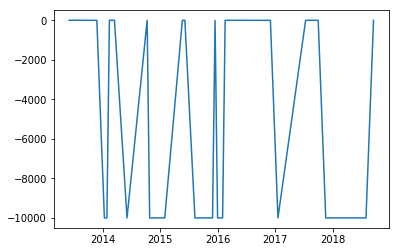

In [40]:
xMid = utm0[0][0] + (number_of_postings[0]/2.)*relative_postings[0][0]    # These must start at utm0 and add a certain 
yMid = utm0[0][1] + (number_of_postings[0]/2.)*relative_postings[0][1]    #   number of the relative_postings vectors
x = m['time']
y = m['vv_masked'].sel(y=yMid,x=xMid,method='nearest').values 
plt.plot(x, y)

In [41]:
# crucial is to distinguish between indexing using coordinate ['time'] and variable ['Image_pair_times']
for t in range(1): 
    xMid = utm0[t][0] + (number_of_postings[t]/2.)*relative_postings[t][0]    # These must start at utm0 and add a certain 
    yMid = utm0[t][1] + (number_of_postings[t]/2.)*relative_postings[t][1]    #   number of the relative_postings vectors
    x = m['time']
    y = m['vv_masked'].sel(y=yMid,x=xMid,method='nearest').values      
    print(x, y)
        

<xarray.DataArray 'time' (time: 47)>
array(['2013-05-31T00:00:00.000000000', '2013-06-16T00:00:00.000000000',
       '2013-11-23T00:00:00.000000000', '2014-01-10T00:00:00.000000000',
       '2014-01-26T00:00:00.000000000', '2014-02-11T00:00:00.000000000',
       '2014-02-27T00:00:00.000000000', '2014-03-15T00:00:00.000000000',
       '2014-06-03T00:00:00.000000000', '2014-10-09T00:00:00.000000000',
       '2014-10-25T00:00:00.000000000', '2014-11-10T00:00:00.000000000',
       '2014-11-26T00:00:00.000000000', '2014-12-12T00:00:00.000000000',
       '2014-12-28T00:00:00.000000000', '2014-12-28T01:00:00.000000000',
       '2015-01-13T00:00:00.000000000', '2015-01-29T00:00:00.000000000',
       '2015-05-21T00:00:00.000000000', '2015-06-06T00:00:00.000000000',
       '2015-08-09T00:00:00.000000000', '2015-08-25T00:00:00.000000000',
       '2015-09-10T00:00:00.000000000', '2015-09-26T00:00:00.000000000',
       '2015-11-29T00:00:00.000000000', '2015-12-15T00:00:00.000000000',
       '2015-1

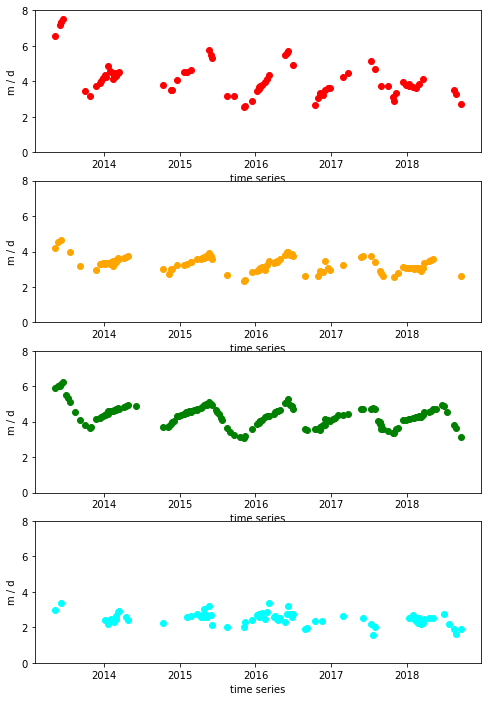

In [50]:
# Create time-series plots for speeds at the centers of the above four respective lateral transects

# Remember that n16s is how many 16-day-interval results we have; and these are m[0], ..., m[n16s - 1]
maxSpeed = 8.
colorsequence = ['red', 'orange', 'green', 'cyan']
fig,axes = plt.subplots(nTransects)
fig.set_size_inches(8,12)
for i in range(nTransects): axes[i].set(ylim=(0., maxSpeed), xlabel='time series', ylabel = 'm / d')
# plt.subplots_adjust(hspace=0.6)

for t in range(4): 
    xMid = utm0[t][0] + (number_of_postings[t]/2.)*relative_postings[t][0]    # These must start at utm0 and add a certain 
    yMid = utm0[t][1] + (number_of_postings[t]/2.)*relative_postings[t][1]    #   number of the relative_postings vectors
    x = m['time']
    y = m['vv_masked'].sel(y=yMid,x=xMid,method='nearest').values 
    axes[t].plot(x, y, 'o', color=colorsequence[t])
        